In [1]:
from google.colab import files

uploaded = files.upload()

Saving attackdata.json to attackdata.json
Saving testdata.json to testdata.json
Saving testdata2.json to testdata2.json
Saving testdata3.json to testdata3.json
Saving testdata4.json to testdata4.json
Saving testdata5.json to testdata5.json
Saving testdata6.json to testdata6.json
Saving testdata7.json to testdata7.json
Saving testdata8.json to testdata8.json
Saving testdata9.json to testdata9.json


In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import torch.nn.functional as F
from tokenizers import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=409496e6018292578d14c1ca2b7543b5183930bddf0338b34dde8ead2d3ba71c
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


###Preprocessing and encoding

In [3]:
import json

# Assuming your JSON file is named "data.json"
with open('testdata.json', 'r') as f:
    data = json.load(f)

dataset=data

with open('testdata2.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata3.json', 'r') as f:
    data = json.load(f)

dataset+=data

with open('testdata4.json', 'r') as f:
    data = json.load(f)

dataset+=data

with open('testdata5.json', 'r') as f:
    data = json.load(f)

dataset+=data
# with open('testdata6.json', 'r') as f:
#     data = json.load(f)

# dataset+=data
with open('testdata7.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata8.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata9.json', 'r') as f:
    data = json.load(f)

dataset+=data

In [ ]:
print(dataset[0])

[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [[{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.00000

In [4]:
print(len(dataset))
print(dataset[0:10])

def hex_to_float32(hex_value):
    max_value=1e6
    # Remove '0x' prefix if present
    hex_value = hex_value.replace('0x', '')

    if not hex_value:
        hex_value = '0'

    # Convert hexadecimal to decimal
    decimal_value = int(hex_value, 16)

    # Scale down large values
    if decimal_value >= max_value:
        decimal_value = decimal_value%max_value

    # Convert decimal to float32
    float32_value = np.float32(decimal_value)

    return float32_value

def preprocess(dataset):
  flat_dataset = [item for sublist in dataset for item in sublist]


  def store_calls(data):
    calllist=[]
    for cur in data:
      cur['CallList'][1]=cur['CallList'][1][0]
      calllist.append(cur['CallList'])

    return calllist
  print(len(flat_dataset))
  calls=store_calls(flat_dataset)
  print(len(calls))
  def unnest(nested_list, level=0):
      encoded_list = []

      for item in nested_list:
          if isinstance(item, list):
              nested_encoded = unnest(item, level + 1)
              encoded_list.extend(nested_encoded)
          else:
              encoded_list.append(hex_to_float32(item["to"]))
              encoded_list.append(hex_to_float32(item["from"]))
              encoded_list.append(float(item["value"]))
              encoded_list.append(float(item["gas"]))
              encoded_list.append(hex_to_float32(item["input"]))
              encoded_list.append(float(level))

      return encoded_list



  unnested_calls=[]
    # Assuming each sublist in input_list is a sequence
  for seq in calls:
    unnested_calls.append(unnest(seq,0))
  return unnested_calls

unnested_calls=preprocess(dataset)

print(unnested_calls[0:10])

1467
[[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [[{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0

In [ ]:
print(dataset[0])

[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000

In [ ]:
import csv
csv_file_path = 'bad_contract.csv'

# Pad sequences to the maximum length in the dataset
max_sequence_length = max(len(seq) for seq in unnested_calls)
padded_data = [seq + [-1] * (max_sequence_length - len(seq)) for seq in unnested_calls]

# Write the list to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in padded_data:
        writer.writerow(row)

print(f'CSV file "{csv_file_path}" has been created successfully.')

CSV file "bad_contract.csv" has been created successfully.


In [5]:
import numpy as np
import pandas as pd

minimum=0.0
maximum=0.0

def min_max_normalize(data, min=0.0, max=0.0):
    global minimum
    global maximum
    # Create a copy of the data array
    normalized_data = data.copy()

    # Find indices of non-zero elements
    nonzero_indices = np.where(normalized_data != 0.0)

    # Find the minimum and maximum values in the data (ignoring 0.0)
    if min + max == 0.0:
      print("This is the first normalization")
      min_value = np.min(normalized_data[nonzero_indices])
      max_value = np.max(normalized_data[nonzero_indices])
      minimum = min_value
      maximum = max_value
    else:
      min_value=min
      max_value=max

    # Normalize the non-zero data to be between 0 and 1
    normalized_data[nonzero_indices] = (normalized_data[nonzero_indices] - min_value) / (max_value - min_value)

    return normalized_data

def encode(data, max_length=0):
    # Calculate the maximum length of any column
    if max_length == 0:
      max_length = max(len(col) for col in data)+100

    padded_data = []
    for seq in data:
        if len(seq) > max_length:
            padded_seq = seq[:max_length]  # Truncate if sequence is too long
        else:
            padded_seq = seq + [0.0] * (max_length - len(seq))  # Pad with zeros
        padded_data.append(padded_seq)

    # Convert to numpy array
    print("SIZE")
    print(len(padded_data))
    print(len(padded_data[0]))
    padded_array = np.array(padded_data, dtype=float)

    # # Normalize each column independently
    normalized_array = np.apply_along_axis(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) != np.min(x) else x, axis=0, arr=padded_array)

    if max_length == 0:
      normalized_array = min_max_normalize(padded_array)
    else:
      normalized_array = min_max_normalize(padded_array, minimum, maximum)

    return normalized_array, max_length

# Example usage
input_data, maxL = encode(unnested_calls)
print(input_data)
print(input_data.shape)
print(maximum)
print(minimum)



SIZE
3100
1030
This is the first normalization
[[0.3378785  0.44741054 0.         ... 0.         0.         0.        ]
 [0.3378785  0.17233212 0.         ... 0.         0.         0.        ]
 [0.3378785  0.52608668 0.         ... 0.         0.         0.        ]
 ...
 [0.3378785  0.42583701 0.         ... 0.         0.         0.        ]
 [0.3378785  0.58427758 0.         ... 0.         0.         0.        ]
 [0.3378785  0.65853659 0.         ... 0.         0.         0.        ]]
(3100, 1030)
999744.0
1.8e-17


In [ ]:
print(type(input_data))

<class 'numpy.ndarray'>


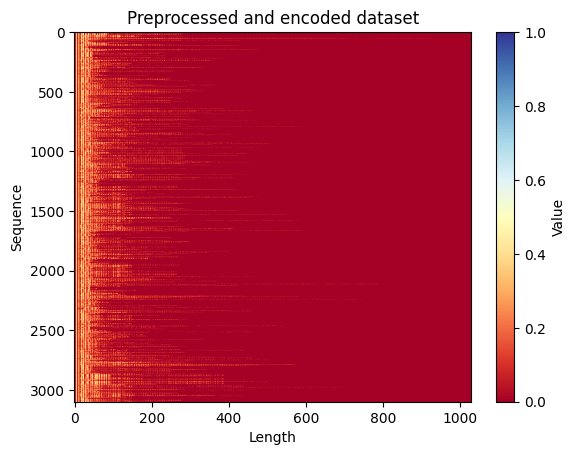

(3100, 1030)


In [6]:
def plot_patterns(data):
  plt.imshow(data, cmap='RdYlBu', aspect='auto')
  plt.colorbar(label='Value')
  plt.title('Preprocessed and encoded dataset')
  plt.xlabel('Length')
  plt.ylabel('Sequence')
  plt.show()


plot_patterns(input_data)
print(input_data.shape)

prep_data=input_data


###DAGMM


Epoch 0/100,TRAIN Loss: 56.0545 - TEST Loss: 5.9665
Epoch 10/100,TRAIN Loss: 0.4567 - TEST Loss: 0.4369
Epoch 20/100,TRAIN Loss: -0.1500 - TEST Loss: -0.1535
Epoch 30/100,TRAIN Loss: -0.4824 - TEST Loss: -0.4967
Epoch 40/100,TRAIN Loss: -0.8501 - TEST Loss: -0.7823
Epoch 50/100,TRAIN Loss: -0.9706 - TEST Loss: -0.8593
Epoch 60/100,TRAIN Loss: -1.0137 - TEST Loss: -0.9188
Epoch 70/100,TRAIN Loss: -1.0543 - TEST Loss: -0.9463
Epoch 80/100,TRAIN Loss: -1.0931 - TEST Loss: -0.9822
Epoch 90/100,TRAIN Loss: -1.1136 - TEST Loss: -0.9998


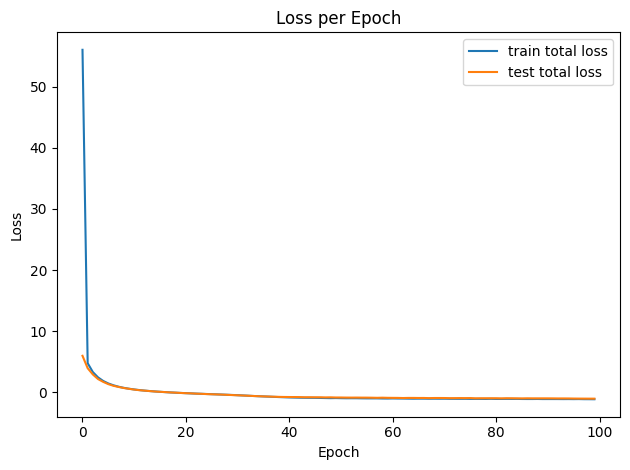

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torch.autograd import Variable
import tensorflow as tf


# Define Deep Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.Tanh(),
            nn.Linear(hidden_dim3, latent_dim-2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim-2, hidden_dim3),
            nn.Tanh(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

# Define DAGMM Model
class DAGMM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm):
        super(DAGMM, self).__init__()
        self.autoencoder = Autoencoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.estimation_network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim3, n_gmm),
            nn.Softmax(dim=1)
        )
        self.phi = torch.zeros(n_gmm)
        self.mu = torch.zeros(n_gmm,latent_dim)
        self.cov = torch.zeros(n_gmm, latent_dim, latent_dim)
        self.n_gmm=n_gmm
        self.latent_dim=latent_dim

    def relative_euclidean_distance(self, a, b):
        return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

    def compute_cosine_similarity(self, x, x_hat):
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        return cosine_similarity

    def cov_diag_loss(self):
        cov_inv = torch.zeros(self.cov.size(0), self.cov.size(1), self.cov.size(1), device=self.cov.device)
        det_cov = torch.zeros(self.cov.size(0), device=self.cov.device)
        cov_diag = 0
        for i in range(self.cov.size(0)):
            cov_k = self.cov[i].clone()
            cov_k += torch.diag(torch.full((self.cov.size(1),), 1e-12, device=self.cov.device))
            cov_inv[i] = torch.linalg.inv(cov_k)
            u, s, v = torch.svd(cov_k)
            det_cov[i] = s.prod() ** 2
            cov_diag += torch.sum(1 / cov_k.diag())

        return cov_diag, cov_inv, det_cov


    def forward(self, x):
        z, x_hat = self.autoencoder(x)
        rec_euclidean = self.relative_euclidean_distance(x, x_hat)
        cosine_similarity = self.compute_cosine_similarity(x,x_hat)
        z_with_errors = torch.cat([z, rec_euclidean.unsqueeze(-1), cosine_similarity.unsqueeze(-1)], dim=1)
        gamma = self.estimation_network(z_with_errors)
        return z, x_hat, z_with_errors, gamma


    def compute_energy(self, z):
        cov_diag, cov_inv, det_cov = self.cov_diag_loss()
        z_mu = (z.unsqueeze(1)- self.mu.unsqueeze(0))
        z_mu_cov_inv = torch.sum(z_mu.unsqueeze(-1) * cov_inv.unsqueeze(0), dim=-2)
        exp_term = torch.exp(-0.5 * torch.sum(z_mu_cov_inv * z_mu, dim=-1))
        positive_exp_term = (-0.5 * torch.sum(z_mu_cov_inv * z_mu, dim=-1)).clamp(min=0)
        max_positive_exp_term = torch.max(positive_exp_term, dim=1, keepdim=True)[0]
        energy = -max_positive_exp_term.squeeze() - torch.log(
            torch.sum(self.phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + 1e-12
        )
        return energy



    def loss_function(self, x, lambda_energy, lambda_cov_diag):
        _, x_hat, z, gamma, = self(x)
        N = gamma.size(0)
        sum_gamma = torch.sum(gamma, dim=0)
        if model.training:
          self.phi = (sum_gamma / N)
          self.mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
          z_mu = (z.unsqueeze(1)- self.mu.unsqueeze(0))
          z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
          self.cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        sample_energy = self.compute_energy(z)
        loss = torch.mean((x - x_hat) ** 2) + lambda_energy * torch.mean(sample_energy) + lambda_cov_diag * self.cov_diag_loss()[0]
        return loss

    def get_energy(self, x,  torch_type=True):
        enc, dec, z, gamma = self(x)
        energy = self.compute_energy(z)
        ret_energy=energy.data.numpy()

        if torch_type == True:
          ret_energy=torch.from_numpy(ret_energy)

        return ret_energy


# Hyperparameters
input_dim = len(prep_data[0])
hidden_dim1 = 400
hidden_dim2 = 200
hidden_dim3 = 30
latent_dim = 3
n_gmm = 5
lr = 1e-4
epochs = 100
lambda_energy=0.1
lambda_cov_diag=0.005
batch_size = 60

# Create model and optimizer
model = DAGMM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25, random_state=40)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training function
def train(model, train_loader, test_loader, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_loss_test = 0.0
        running_loss = 0.0
        test_running_loss=0.0
        count=0
        count_test=0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            total_loss = model.loss_function(data, lambda_energy, lambda_cov_diag)
            model.zero_grad()
            total_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            running_loss += total_loss.item()

            loss = []
            loss.append( total_loss.item())
            count+=1
        epoch_loss=running_loss/count
        train_losses.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader):
                test_loss = model.loss_function(data, lambda_energy, lambda_cov_diag)
                loss = []
                loss.append( test_loss.item())
                test_running_loss += test_loss.item()
                count_test+=1
        epoch_loss_test=test_running_loss/count_test
        test_losses.append(epoch_loss_test)
        if epoch%10 == 0:
          print(f"Epoch {epoch}/{num_epochs},TRAIN Loss: {epoch_loss:.4f} - TEST Loss: {epoch_loss_test:.4f}")
    return train_losses, test_losses


# Plotting function
def plot_losses(loss_data):
    plt.plot(loss_data[0], label="train total loss")
    plt.plot(loss_data[1], label="test total loss")
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
    plt.show()



# Train the model
losses = train(model, train_loader, test_loader, optimizer, epochs)

# Test the model
# test_losses = test(model, test_loader)

# avg_test_energy = sum(test_energy) / len(test_energy)

# Plot losses
plot_losses(losses)  # Broadcasting test loss to match training loss length
# print("Average Test Energy: ", avg_test_energy)
# plot_losses(test_losses)

threshold -8.306798524856642
Detected 10 anomalies in test.
Detected 21 anomalies in train.


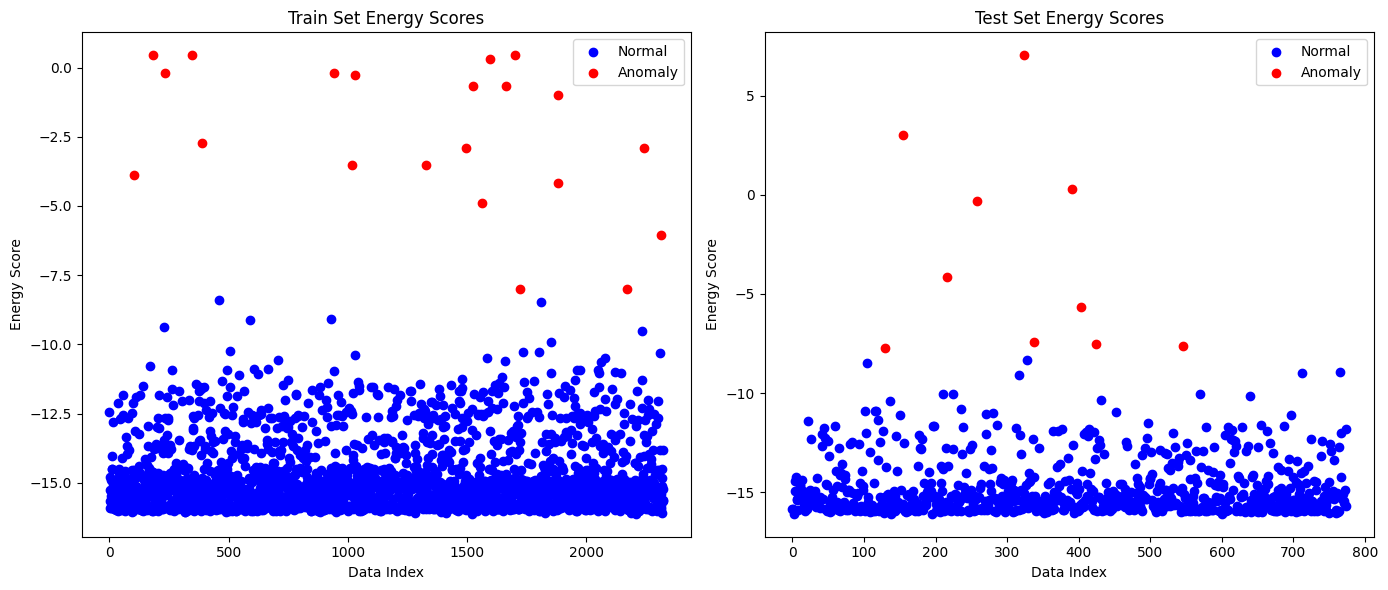

In [ ]:
import matplotlib.pyplot as plt

# Compute energy scores for train and test data
train_energy = model.get_energy(train_data)
test_energy = model.get_energy(test_data)

all_energy=np.concatenate((train_energy, test_energy), axis=0)

threshold = np.percentile(all_energy, 99)
print(f"threshold {threshold}")

anomaly_indices_test=torch.where(test_energy >= threshold)[0]

# anomaly_indices = (np.array(eval_energy) > threshold).astype(int)[0]
print(f"Detected {len(anomaly_indices_test)} anomalies in test.")

anomaly_indices_train=torch.where(train_energy >= threshold)[0]

# anomaly_indices = (np.array(eval_energy) > threshold).astype(int)[0]
print(f"Detected {len(anomaly_indices_train)} anomalies in train.")

# Create plots
plt.figure(figsize=(14, 6))

# Train set plot
plt.subplot(1, 2, 1)
normal_train_indices = torch.where(train_energy < threshold)[0]
anomaly_train_indices = torch.where(train_energy >= threshold)[0]
plt.scatter(normal_train_indices, train_energy[normal_train_indices], c='blue', label='Normal')
plt.scatter(anomaly_train_indices, train_energy[anomaly_train_indices], c='red', label='Anomaly')
plt.title('Train Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend()

# Test set plot
plt.subplot(1, 2, 2)
normal_test_indices = torch.where(test_energy < threshold)[0]
anomaly_test_indices = torch.where(test_energy >= threshold)[0]
plt.scatter(normal_test_indices, test_energy[normal_test_indices], c='blue', label='Normal')
plt.scatter(anomaly_test_indices, test_energy[anomaly_test_indices], c='red', label='Anomaly')
plt.title('Test Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# Find the index of the maximum energy score
max_energy_index = torch.argmax(train_energy)
print(train_energy[torch.argmax(train_energy)])

print("Index of the maximum energy score:", max_energy_index.item())
matching=train_data[max_energy_index]
matching_index = None
for i, node in enumerate(torch.tensor(prep_data, dtype=torch.float)):
    if np.array_equal(node, matching):
        matching_index = i
        break

flat_dataset = [item for sublist in dataset for item in sublist]
print("Index of matching node:", matching_index)
print("in dataset: ", flat_dataset[matching_index])

max_energy_index = torch.argmax(test_energy)
print(test_energy[max_energy_index])

print("Index of the maximum energy score:", max_energy_index.item())
matching=test_data[max_energy_index]
matching_index = None
for i, node in enumerate(torch.tensor(prep_data, dtype=torch.float)):
    if np.array_equal(node, matching):
        matching_index = i
        break

flat_dataset = [item for sublist in dataset for item in sublist]
print("Index of matching node:", matching_index)
print("in dataset: ", flat_dataset[matching_index])

tensor(0.4424)
Index of the maximum energy score: 181
Index of matching node: 2145
in dataset:  {'BlockNumber': 15604975, 'TxHash': '0xb8bec24757cca9fa83d708367472a3d1c6998a614ba6accc8af28b0677d7af6b', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x0e4d3675adb96de93dcd85e394508831ab9f0578', 'value': '0.0', 'gas': '0.000000000000095546', 'input': '0x69277b67'}, [{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000045565', 'input': '0x69277b67'}, [{'to': '0xe8c7ce3d2596675af784a4ee26c405e595cb64f3', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000003467', 'input': '0x4da17819'}, {'to': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000013995', 'input': '0x2e1a7d4d'}, [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0xc02aaa

3
3
90
48
SIZE
3
1030


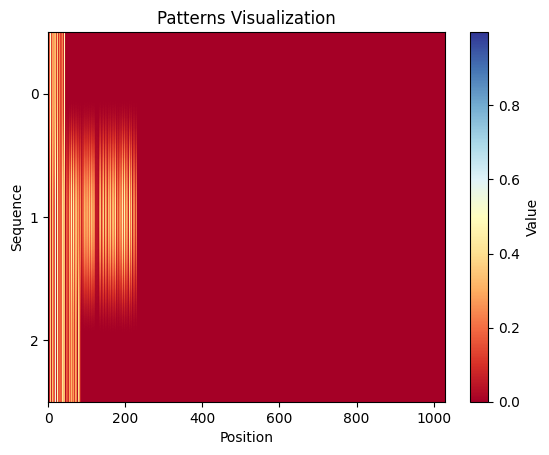

(3, 1030)
eval 1:  tensor([ 27.6310, -10.7674, -15.3973])


In [ ]:
with open('attackdata.json', 'r') as f:
    data = json.load(f)

anomally_dataset=[data]

anom1 = preprocess(anomally_dataset)

print(len(unnested_calls[0]))
print(len(anom1[0]))
anom_fin,_=encode(anom1, maxL)
anom = torch.tensor(anom_fin, dtype=torch.float)

def plot_patterns(data):
  plt.imshow(data, cmap='RdYlBu', aspect='auto')
  plt.colorbar(label='Value')
  plt.title('Patterns Visualization')
  plt.xlabel('Position')
  plt.ylabel('Sequence')
  plt.gca().yaxis.get_major_locator().set_params(integer=True)
  plt.show()


plot_patterns(anom_fin)
print(anom_fin.shape)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  res1=model.get_energy(anom)


print("eval 1: ", res1)


<class 'torch.Tensor'>
tensor([ 27.6310, -10.7674, -15.3973])
Found you


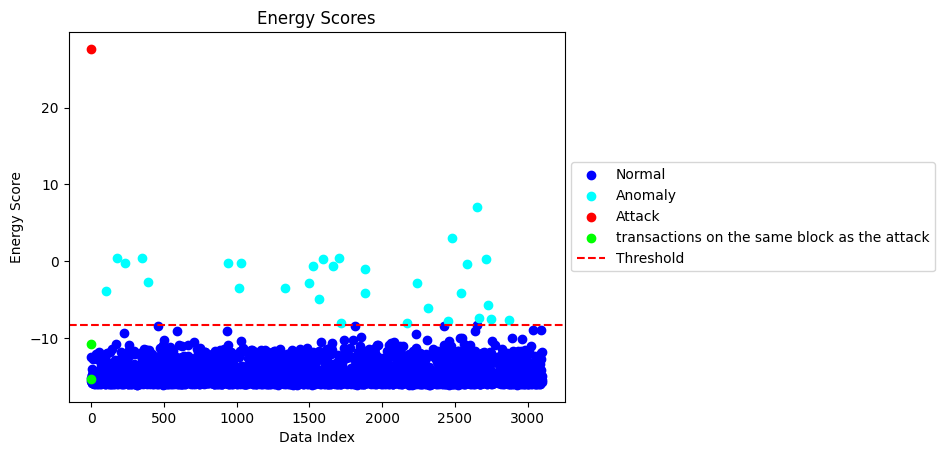

In [ ]:
print(type(test_energy))

normal_energy=torch.cat((train_energy, test_energy), dim=0)

normal_indices = torch.where(normal_energy < threshold)[0]
anomaly_indices = torch.where(normal_energy >= threshold)[0]
attack = res1.detach()


plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
print(attack)
plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

if(attack[0]>threshold):
  print("Found you")
else:
  print("try again")


162
162
SIZE
162
1030


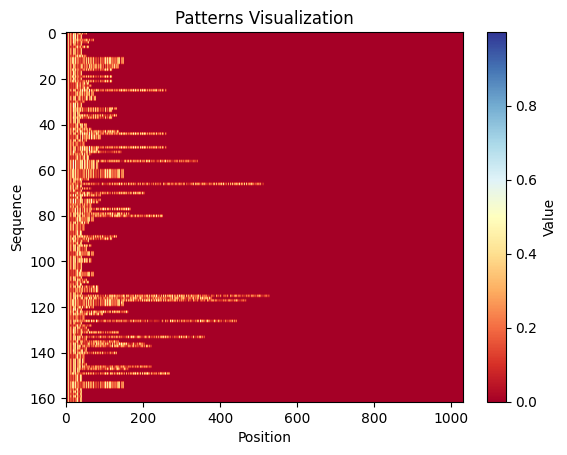

In [ ]:
with open('testdata6.json', 'r') as f:
    data = json.load(f)

example_dataset=data

# with open('attackdata.json', 'r') as f:
#     data = json.load(f)

# example_dataset+=[data]


exam1 = preprocess(example_dataset)

exam_fin, _=encode(exam1, maxL)
exam = torch.tensor(exam_fin, dtype=torch.float)



plot_patterns(exam_fin)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  res2=model.get_energy(exam)



[]

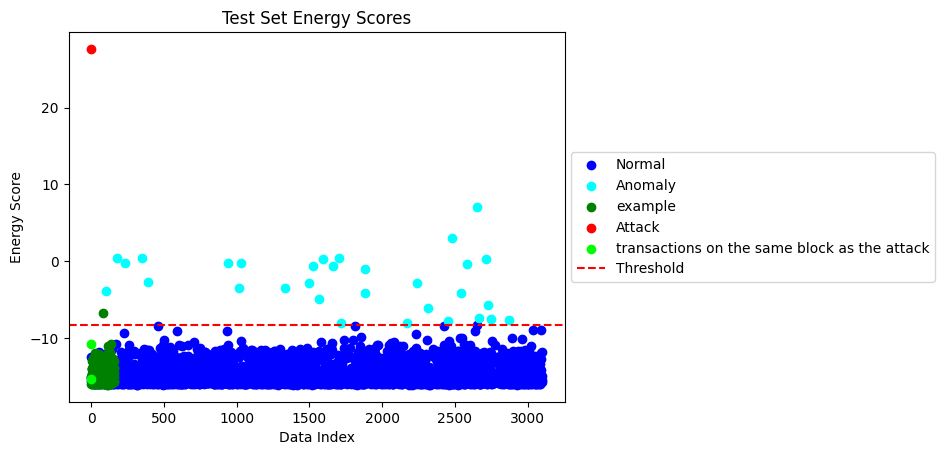

In [ ]:
example = res2.detach()

plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
plt.scatter(range(len(example)), example, c='green', label='example')

plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Test Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.plot()


In [ ]:
max_energy_index = torch.argmax(example)
print("Index of the maximum energy score:", max_energy_index.item())
matching=example[max_energy_index].item()
matching_index = None
# for i, node in enumerate(torch.tensor(exam_fin, dtype=torch.float)):
#     if np.array_equal(node, matching):
#         matching_index = i
#         break

flat_dataset = [item for sublist in example_dataset for item in sublist]
print("Energy found:", matching)
if matching != None:
  print("in dataset: ", flat_dataset[max_energy_index])

Index of the maximum energy score: 79
Energy found: -6.75466251373291
in dataset:  {'BlockNumber': 15607678, 'TxHash': '0x88fe32f8a541b3d5a3cba5cc491319ba206c47bc5d0b3dfea04267e25f091bad', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0xd56b082b83b4fc3f94e534046826ae69c4e96092', 'value': '0.0', 'gas': '0.000000000000453314', 'input': '0x69277b67'}, [{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000481899', 'input': '0x69277b67'}, [{'to': '0xe8c7ce3d2596675af784a4ee26c405e595cb64f3', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000010467', 'input': '0xd3d63cbc'}, [{'to': '0x2e4784446a0a06df3d1a040b03e1680ee266c35a', 'from': '0xe8c7ce3d2596675af784a4ee26c405e595cb64f3', 'value': '0.0', 'gas': '0.000000000000002696', 'input': '0x3850c7bd'}], {'to': '0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7', 'from': '0xbadc0defafcf6d4239

In [ ]:
# found=[]
# threshold_value=[]
# attack_energy=[]
# example_above_thres=[]
# train_above_attack=[]
# test_above_attack=[]
# example_above_attack=[]

In [ ]:
def print_metrics(threshold, train_energy, test_energy, attack, example):

  print("the attack is found by the model: ", (attack[0] >= threshold).item())
  print("The threshold is: ", threshold)
  print("The energy value of the attack is: ", attack[0].item())
  print("the highest energy in train is: ", train_energy[torch.argmax(train_energy)])
  print("the highest energy in test is: ", test_energy[torch.argmax(test_energy)])
  print("the highest energy in example is: ", example[torch.argmax(example)])
  found.append((attack[0] >= threshold).item())
  threshold_value.append(threshold)
  attack_energy.append(attack[0].item())

  print("------------------")

  print("number of transactions with energy greater or equal to the threshold in train is: ", len(torch.where(train_energy >= threshold)[0]), " out of: ", len(train_energy))
  print("number of transactions with energy greater or equal to the threshold in test is: ", len(torch.where(test_energy >= threshold)[0]), " out of: ", len(test_energy))
  print("number of transactions with energy greater or equal to the threshold in example is: ", len(torch.where(example >= threshold)[0]), " out of: ", len(example))
  example_above_thres.append(len(torch.where(example >= threshold)[0]))
  print("------------------")

  print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(train_energy >= attack[0])[0]), " out of: ", len(train_energy))
  print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(test_energy >= attack[0])[0]), " out of: ", len(test_energy))
  print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example >= attack[0])[0]), " out of: ", len(example))
  train_above_attack.append(len(torch.where(train_energy >= attack[0])[0]))
  test_above_attack.append(len(torch.where(test_energy >= attack[0])[0]))
  example_above_attack.append(len(torch.where(example >= attack[0])[0]))
  print("------------------")

  print("average energy value in train is: ",torch.mean(train_energy))
  print("average energy value in test is: ",torch.mean(test_energy))
  print("average energy value in example is: ",torch.mean(example))

print_metrics(threshold, train_energy, test_energy, attack, example)

the attack is found by the model:  True
The threshold is:  -1.0751998895407822
The energy value of the attack is:  27.63102149963379
the highest energy in train is:  tensor(27.5519)
the highest energy in test is:  tensor(16.9310)
the highest energy in example is:  tensor(-2.5878)
------------------
number of transactions with energy greater or equal to the threshold in train is:  24  out of:  2325
number of transactions with energy greater or equal to the threshold in test is:  7  out of:  775
number of transactions with energy greater or equal to the threshold in example is:  0  out of:  162
------------------
number of transactions with energy greater or equal to the attack in train is:  0  out of:  2325
number of transactions with energy greater or equal to the attack in test is:  0  out of:  775
number of transactions with energy greater or equal to the attack in example is:  0  out of:  162
------------------
average energy value in train is:  tensor(-14.4311)
average energy value

In [ ]:
def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

print(len(found))
print("av found : ", mean(found))
print("av threshold_value : ", mean(threshold_value))
print("av attack_energy : ", mean(attack_energy))
print("av example_above_thres : ", mean(example_above_thres))
print("av train_above_attack : ", mean(train_above_attack))
print("av test_above_attack : ", mean(test_above_attack))
print("av example_above_attack : ", mean(example_above_attack))

10
av found :  1.0
av threshold_value :  -1.428170361578536
av attack_energy :  27.63102149963379
av example_above_thres :  1.4
av train_above_attack :  0.1
av test_above_attack :  0.5
av example_above_attack :  0.0


###True False

In i=  0
Epoch 0/100,TRAIN Loss: 27.5317 - TEST Loss: 9.0608
Epoch 10/100,TRAIN Loss: -0.0143 - TEST Loss: 1.0944
Epoch 20/100,TRAIN Loss: -0.5540 - TEST Loss: -0.0089
Epoch 30/100,TRAIN Loss: -0.8351 - TEST Loss: -0.4756
Epoch 40/100,TRAIN Loss: -0.9859 - TEST Loss: -0.6994
Epoch 50/100,TRAIN Loss: -1.0820 - TEST Loss: -0.8205
Epoch 60/100,TRAIN Loss: -1.1226 - TEST Loss: -0.8990
Epoch 70/100,TRAIN Loss: -1.1429 - TEST Loss: -0.9211
Epoch 80/100,TRAIN Loss: -1.1649 - TEST Loss: -0.9778
Epoch 90/100,TRAIN Loss: -1.1837 - TEST Loss: -1.0279


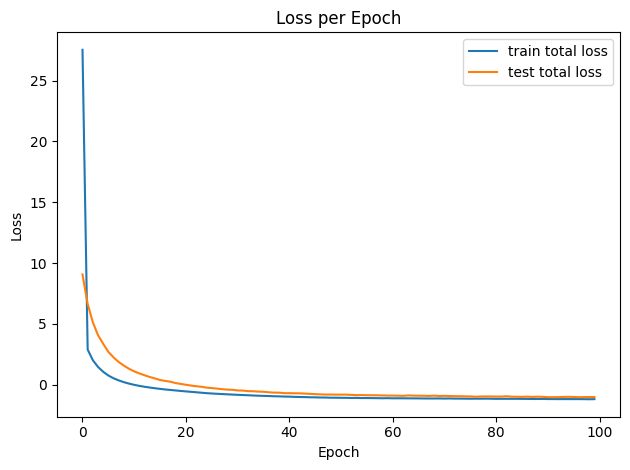

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9753086419753086
False possitive:  0.024691358024691357
False negative:  0.0
True possitive:  1.0
True negative:  0.9753086419753086
False possitive:  0.024691358024691357
False negative:  0.0
True possitive:  1.0
True negative:  0.9567901234567902
False possitive:  0.043209876543209874
False negative:  0.0
True possitive:  1.0
True negative:  0.9382716049382716
False possitive:  0.06172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.7530864197530864
False possitive:  0.24691358024691357
False negative:  0.0
In i=  1
Epoch 0/100,TRAIN Loss: 45.7808 - TEST Loss: 15.0167
Epoch 10/100,TRAIN Loss: 0.6268 - TEST Loss: 2.3680
Epoch 20/100,TRAIN Loss: 0.0278 - TEST Loss: 0.9559
Epoch 30/100,TRAIN Loss: -0.2486 - TEST Loss: 0.36

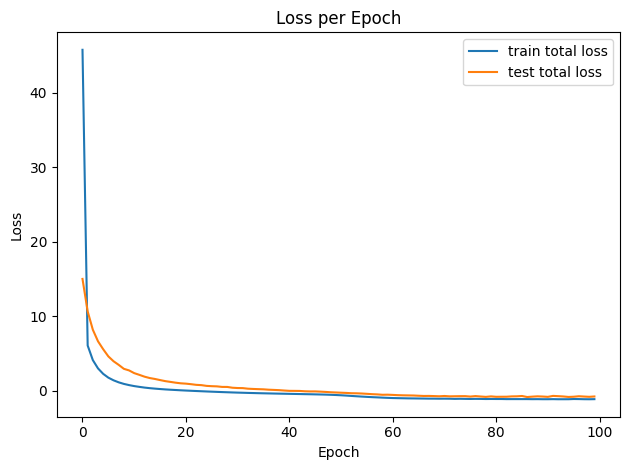

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  0.9753086419753086
False possitive:  0.024691358024691357
False negative:  0.0
True possitive:  1.0
True negative:  0.9753086419753086
False possitive:  0.024691358024691357
False negative:  0.0
True possitive:  1.0
True negative:  0.9753086419753086
False possitive:  0.024691358024691357
False negative:  0.0
True possitive:  1.0
True negative:  0.9753086419753086
False possitive:  0.024691358024691357
False negative:  0.0
True possitive:  1.0
True negative:  0.9197530864197531
False possitive:  0.08024691358024691
False negative:  0.0
True possitive:  1.0
True negative:  0.9012345679012346
False possitive:  0.09876543209876543
False negative:  0.0
True possitive:  1.0
True negative:  0.808641975308642
False possitive:  0.19135802469135801
False negative:  0.0
In i=  2
Epoch 0/100,TRAIN Loss: 26.2423 - TEST Loss: 4.2010
Epoch 10/100,TRAIN Loss: 0.1569 - TEST Loss: 0.1210
Epoch 20/100,TRAIN Loss: -0.3799 - TEST L

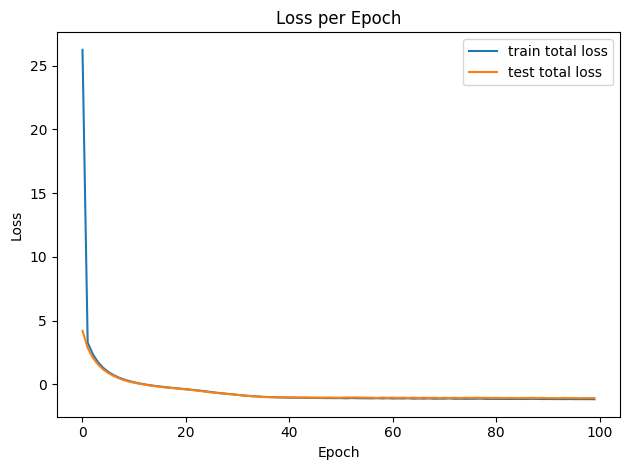

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9938271604938271
False possitive:  0.006172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.9197530864197531
False possitive:  0.08024691358024691
False negative:  0.0
True possitive:  1.0
True negative:  0.8333333333333334
False possitive:  0.16666666666666666
False negative:  0.0
True possitive:  1.0
True negative:  0.6604938271604939
False possitive:  0.3395061728395062
False negative:  0.0
In i=  3
Epoch 0/100,TRAIN Loss: 22.8032 - TEST Loss: 4.0464
Epoch 10/100,TRAIN Loss: 0.0550 - TEST Loss: -0.0732
Epoch 20/100,TRAIN Loss: -0.5323 - TEST Loss: -0.5911
Epoch 30/100,TRAIN Loss: -0.7590 - TEST Loss: -0.7774
Epoch 40/100,TRAIN Loss: -0.

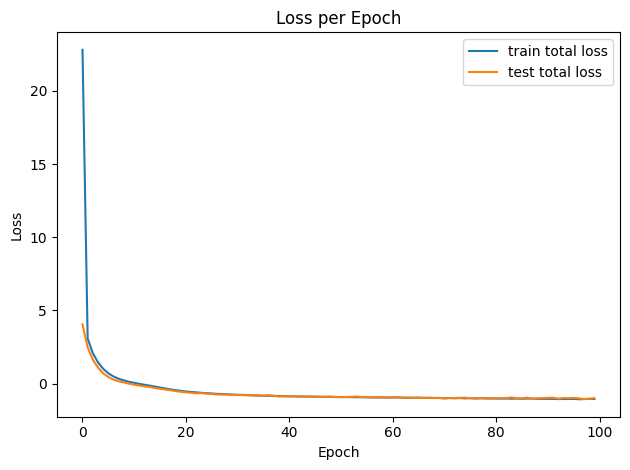

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9876543209876543
False possitive:  0.012345679012345678
False negative:  0.0
True possitive:  1.0
True negative:  0.9814814814814815
False possitive:  0.018518518518518517
False negative:  0.0
True possitive:  1.0
True negative:  0.9444444444444444
False possitive:  0.05555555555555555
False negative:  0.0
True possitive:  1.0
True negative:  0.8950617283950617
False possitive:  0.10493827160493827
False negative:  0.0
True possitive:  1.0
True negative:  0.6666666666666666
False possitive:  0.3333333333333333
False negative:  0.0
In i=  4
Epoch 0/100,TRAIN Loss: 33.5944 - TEST Loss: 4.0135
Epoch 10/100,TRAIN Loss: 0.4730 - TEST Loss: 0.2330
Epoch 20/100,TRAIN Loss: -0.2324 - TEST Loss: -0.3289
Epoch 30/100,TRAIN Loss: -0.7461 - TEST Loss: -0.83

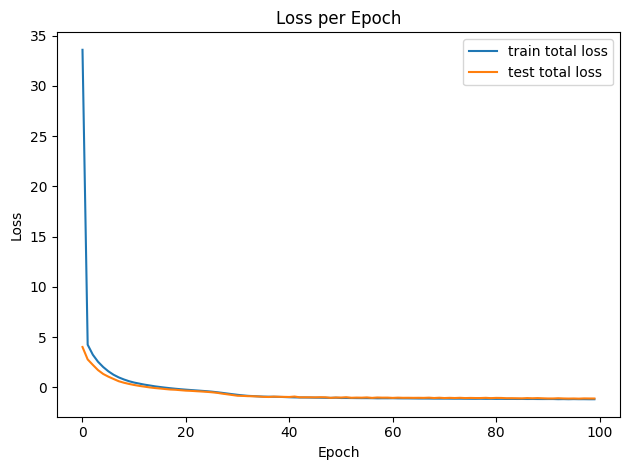

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9938271604938271
False possitive:  0.006172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.9938271604938271
False possitive:  0.006172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.9259259259259259
False possitive:  0.07407407407407407
False negative:  0.0
True possitive:  1.0
True negative:  0.8888888888888888
False possitive:  0.1111111111111111
False negative:  0.0
True possitive:  1.0
True negative:  0.7407407407407407
False possitive:  0.25925925925925924
False negative:  0.0
In i=  5
Epoch 0/100,TRAIN Loss: 26.5429 - TEST Loss: 3.3307
Epoch 10/100,TRAIN Loss: 0.0865 - TEST Loss: -0.0016
Epoch 20/100,TRAIN Loss: -0.4914 - TEST Loss: -0.4971
Epoch 30/100,TRAIN Loss: -0.8110 - TEST Loss: -0.7

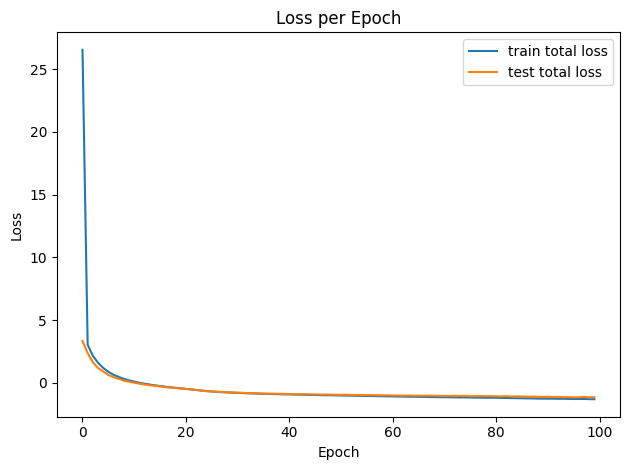

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9382716049382716
False possitive:  0.06172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.8950617283950617
False possitive:  0.10493827160493827
False negative:  0.0
True possitive:  1.0
True negative:  0.7345679012345679
False possitive:  0.2654320987654321
False negative:  0.0
In i=  6
Epoch 0/100,TRAIN Loss: 26.8031 - TEST Loss: 3.3268
Epoch 10/100,TRAIN Loss: 0.0222 - TEST Loss: -0.1567
Epoch 20/100,TRAIN Loss: -0.5321 - TEST Loss: -0.6214
Epoch 30/100,TRAIN Loss: -0.7296 - TEST Loss: -0.7551
Epoch 40/100,TRAIN Loss: -0.8135 - TEST Loss: -0.8076
Epoch 

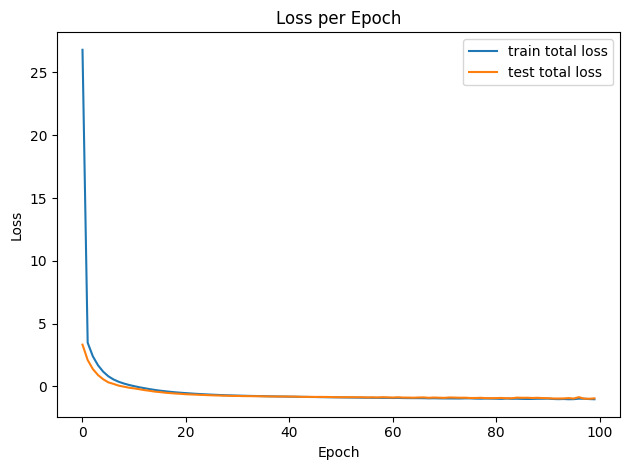

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9938271604938271
False possitive:  0.006172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.9814814814814815
False possitive:  0.018518518518518517
False negative:  0.0
True possitive:  1.0
True negative:  0.9814814814814815
False possitive:  0.018518518518518517
False negative:  0.0
True possitive:  1.0
True negative:  0.9506172839506173
False possitive:  0.04938271604938271
False negative:  0.0
True possitive:  1.0
True negative:  0.8950617283950617
False possitive:  0.10493827160493827
False negative:  0.0
True possitive:  1.0
True negative:  0.6234567901234568
False possitive:  0.3765432098765432
False negative:  0.0
In i=  7
Epoch 0/100,TRAIN Loss: 20.1554 - TEST Loss: 3.1434
Epoch 10/100,TRAIN Loss: -0.2841 - TEST Loss: -0.3656
Epoch 20/100,TRAIN Loss: -0.7623 - TEST Loss: -0.7903
Epoch 30/100,TRAI

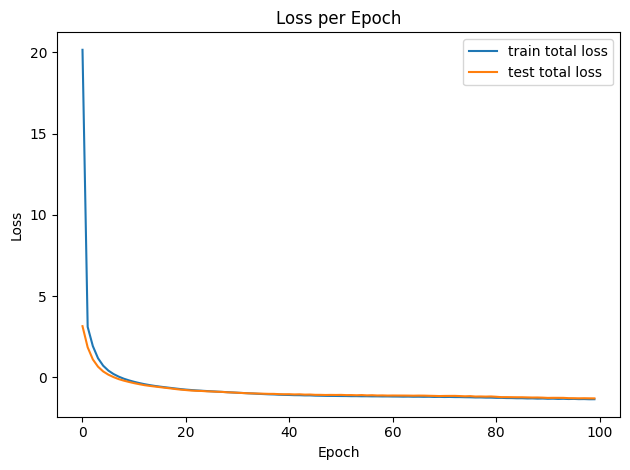

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9938271604938271
False possitive:  0.006172839506172839
False negative:  0.0
True possitive:  1.0
True negative:  0.9629629629629629
False possitive:  0.037037037037037035
False negative:  0.0
True possitive:  1.0
True negative:  0.9012345679012346
False possitive:  0.09876543209876543
False negative:  0.0
True possitive:  1.0
True negative:  0.7222222222222222
False possitive:  0.2777777777777778
False negative:  0.0
In i=  8
Epoch 0/100,TRAIN Loss: 21.7427 - TEST Loss: 3.5985
Epoch 10/100,TRAIN Loss: -0.0982 - TEST Loss: -0.2401
Epoch 20/100,TRAIN Loss: -0.6407 - TEST Loss: -0.6443
Epoch 30/100,TRAIN Loss: -0.8015 - TEST Loss: -0.7634
Epoch 40/100,TRAIN Loss: -

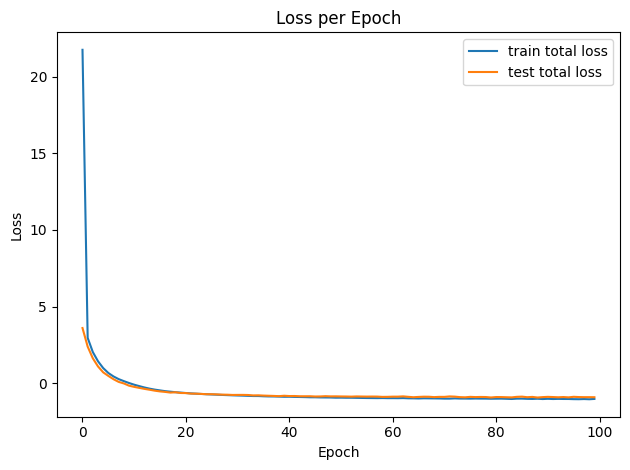

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9876543209876543
False possitive:  0.012345679012345678
False negative:  0.0
True possitive:  1.0
True negative:  0.9876543209876543
False possitive:  0.012345679012345678
False negative:  0.0
True possitive:  1.0
True negative:  0.9444444444444444
False possitive:  0.05555555555555555
False negative:  0.0
True possitive:  1.0
True negative:  0.8888888888888888
False possitive:  0.1111111111111111
False negative:  0.0
True possitive:  1.0
True negative:  0.6975308641975309
False possitive:  0.30246913580246915
False negative:  0.0
In i=  9
Epoch 0/100,TRAIN Loss: 24.9185 - TEST Loss: 2.5170
Epoch 10/100,TRAIN Loss: 0.0605 - TEST Loss: -0.1663
Epoch 20/100,TRAIN Loss: -0.5252 - TEST Loss: -0.6658
Epoch 30/100,TRAIN Loss: -0.8631 - TEST Loss: -0.9

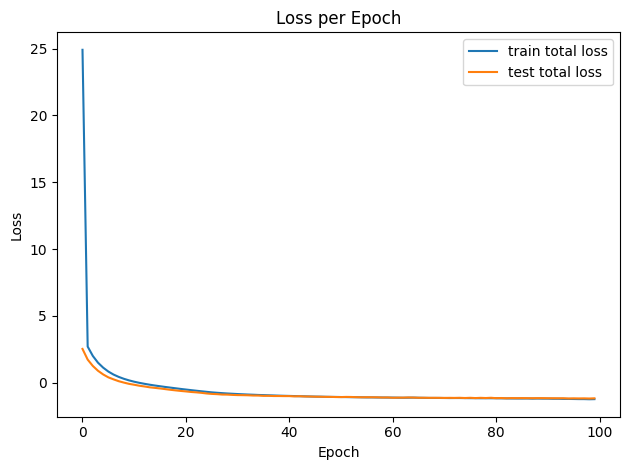

162
162
SIZE
162
1030
3
3
SIZE
3
1030
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9506172839506173
False possitive:  0.04938271604938271
False negative:  0.0
True possitive:  1.0
True negative:  0.8765432098765432
False possitive:  0.12345679012345678
False negative:  0.0
True possitive:  1.0
True negative:  0.6975308641975309
False possitive:  0.30246913580246915
False negative:  0.0

Results after 10 model trains
_____________________________
For threshold =  0.01
False possitive:  1.0
True possitive:  0.0024691358024691358
False negative:  0.9975308641975309
True negative:  0.0
For threshold =  0.1
False possitive:  1.0
True possitive:  0.0030864197530864196

In [ ]:
input_dim = len(prep_data[0])
hidden_dim1 = 400
hidden_dim2 = 200
hidden_dim3 = 30
latent_dim = 3
n_gmm = 5
lr = 1e-4
epochs = 100
lambda_energy=0.1
lambda_cov_diag=0.005
batch_size = 60

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

def stats(example, attack, threshold):
  res=[]
  for thres in threshold:
    false_pos=len(torch.where(example >= thres)[0])/len(example)
    true_pos=len(torch.where(attack >= thres)[0])/len(attack)
    false_neg=len(torch.where(attack < thres)[0])/len(attack)
    true_neg=len(torch.where(example < thres)[0])/len(example)
    res.append([true_pos, true_neg, false_pos, false_neg])

  return res



def train_model(model, prep_data, optimizer, epochs):
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


  losses = train(model, train_loader, test_loader, optimizer, epochs)
  plot_losses(losses)
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    train_energy = model.get_energy(train_data)
    test_energy = model.get_energy(test_data)

    all_energy=np.concatenate((train_energy, test_energy), axis=0)

    threshold = [np.percentile(all_energy, 99.99),np.percentile(all_energy, 99.9),np.percentile(all_energy, 99.5),np.percentile(all_energy, 99),np.percentile(all_energy, 95),np.percentile(all_energy, 90),np.percentile(all_energy, 75)]

    with open('testdata6.json', 'r') as f:
      data = json.load(f)

    example_dataset=data
    exam1 = preprocess(example_dataset)
    exam_fin, _=encode(exam1, maxL)
    exam = torch.tensor(exam_fin, dtype=torch.float)
    res2=model.get_energy(exam)
    example = res2.detach()
    with open('attackdata.json', 'r') as f:
      data = json.load(f)
    anomally_dataset=[data]
    anom1 = preprocess(anomally_dataset)
    anom_fin,_=encode(anom1, maxL)
    anom = torch.tensor(anom_fin, dtype=torch.float)
    res1=model.get_energy(anom)
    attack = res1.detach()

    ftpn=stats(example, torch.tensor([attack[0]], dtype=torch.float), threshold)
    return ftpn
i=0
while(i<10):
  print("In i= ", i)
  model = DAGMM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  results = train_model(model, prep_data, optimizer, epochs)
  count=0
  for res in results:
    print("True possitive: ", res[0])
    print("True negative: ", res[1])
    print("False possitive: ", res[2])
    print("False negative: ", res[3])
    true_pos_arr[count].append(res[0])
    true_neg_arr[count].append(res[1])
    false_pos_arr[count].append(res[2])
    false_neg_arr[count].append(res[3])
    count+=1
  i+=1
thresholds=[0.01, 0.1, 0.5, 1, 5, 10, 25]
print()
print("Results after 10 model trains")
print("_____________________________")
count=0
for tr in thresholds:
  print("For threshold = ", tr)
  print("False possitive: ", mean(true_pos_arr[count]))
  print("True possitive: ", mean(false_pos_arr[count]))
  print("False negative: ", mean(true_neg_arr[count]))
  print("True negative: ", mean(false_neg_arr[count]))
  count+=1




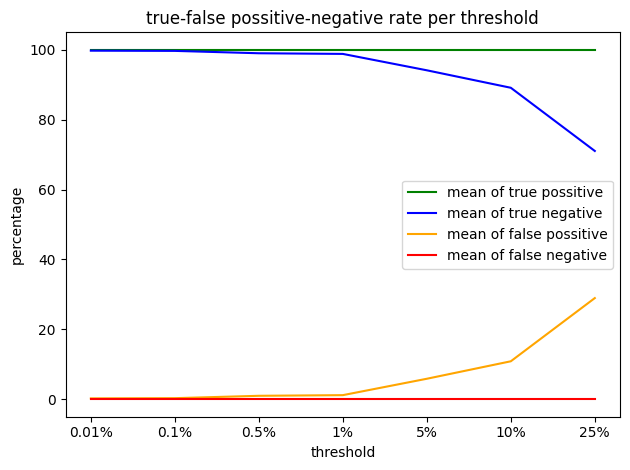

In [ ]:
  mtp=[]
  mfp=[]
  mtn=[]
  mfn=[]
  t=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
  count=0
  for tr in thresholds:
    mtp.append(mean(true_pos_arr[count])*100)
    mtn.append(mean(true_neg_arr[count])*100)
    mfp.append(mean(false_pos_arr[count])*100)
    mfn.append(mean(false_neg_arr[count])*100)
    count+=1

  plt.plot(t, mtp, label="mean of true possitive", c='green')
  plt.plot(t, mtn, label="mean of true negative", c='blue')
  plt.plot(t, mfp, label="mean of false possitive", c='orange')
  plt.plot(t, mfn, label="mean of false negative", c='red')
  plt.title('true-false possitive-negative rate per threshold')
  plt.xlabel('threshold')
  plt.ylabel('percentage')
  plt.legend()
  plt.tight_layout()
  # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
  plt.show()


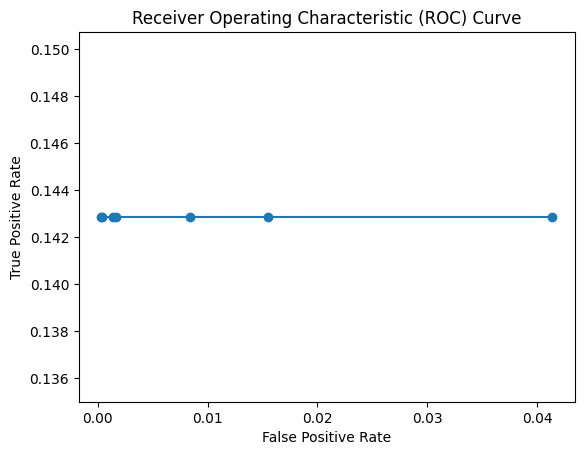

In [ ]:

total_positives = sum(mtp) + sum(mfn)
total_negatives = sum(mtn) + sum(mfp)

# Calculate TPR and FPR
TPR = [tp / total_positives for tp in mtp]
FPR = [fp / total_negatives for fp in mfp]

# Plotting the ROC curve
plt.plot(FPR, TPR, marker='o')


# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Displaying the plot
plt.show()

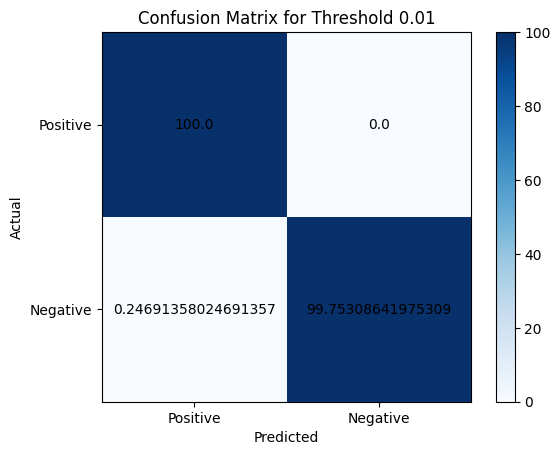

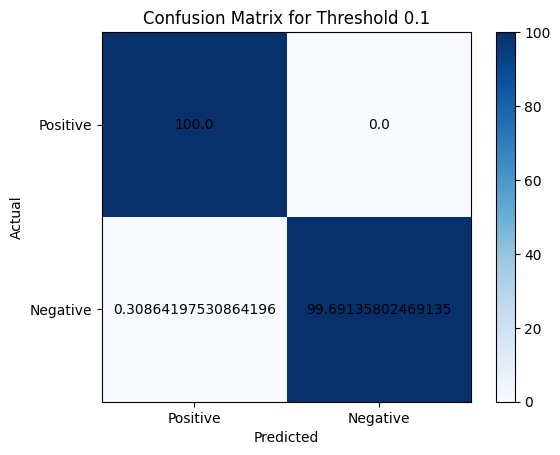

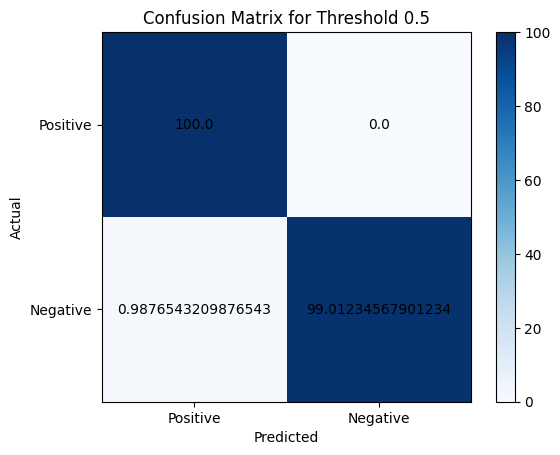

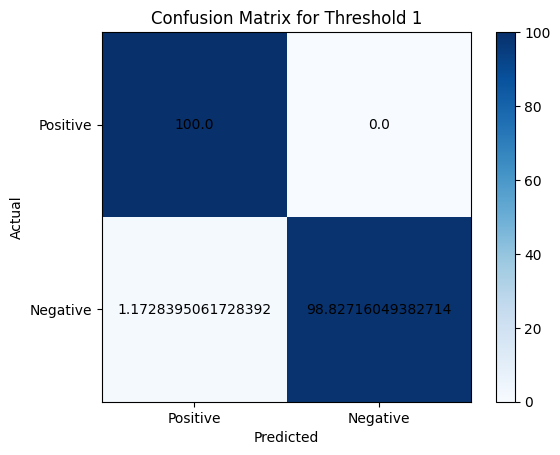

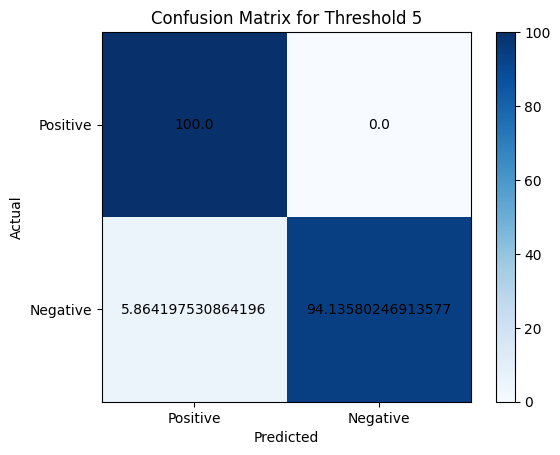

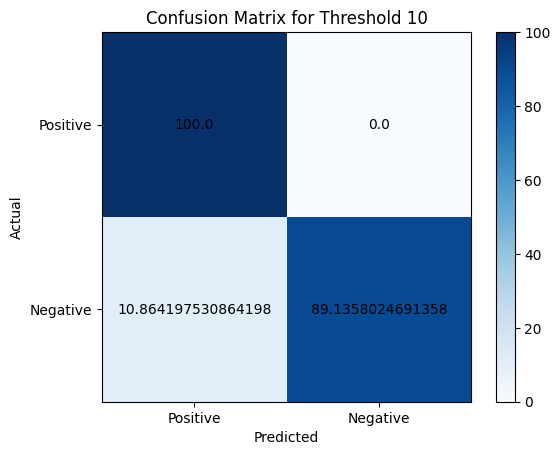

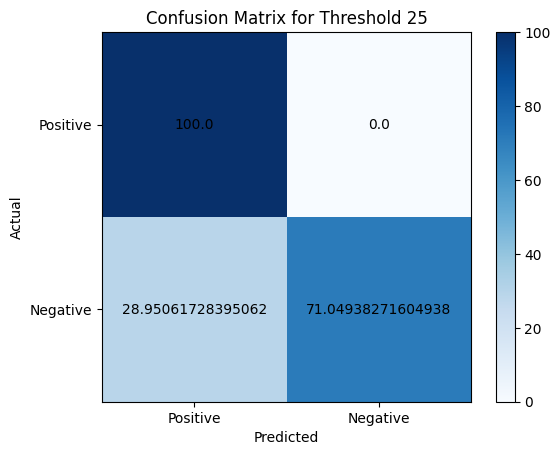

In [ ]:
# Sample percentages of TP, TN, FP, FN for different thresholds


for i, threshold in enumerate(thresholds):

    total_positives = mtp[i] + mfn[i]
    total_negatives = mtn[i] + mfp[i]

    # Calculate TP, TN, FP, FN
    TP = mtp[i] / 100 * total_positives
    TN = mtn[i] / 100 * total_negatives
    FP = mfp[i] / 100 * total_negatives
    FN = mfn[i] / 100 * total_positives

    # Creating confusion matrix
    confusion_matrix = np.array([[TP, FN], [FP, TN]])

    # Plotting the confusion matrix
    plt.figure()
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # Adding labels
    plt.title(f'Confusion Matrix for Threshold {threshold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks([0, 1], ['Positive', 'Negative'])
    plt.yticks([0, 1], ['Positive', 'Negative'])

    # Displaying the plot
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            plt.text(j, i, str(confusion_matrix[i, j]), va='center', ha='center')

plt.show()


In [10]:
with open('testdata6.json', 'r') as f:
  data = json.load(f)

example_dataset=data
exam1 = preprocess(example_dataset)
exam_fin, _=encode(exam1, maxL)
exam = torch.tensor(exam_fin, dtype=torch.float)

with open('attackdata.json', 'r') as f:
  data = json.load(f)
anomally_dataset=[data]
anom1 = preprocess(anomally_dataset)
anom_fin,_=encode(anom1, maxL)
anom = torch.tensor(anom_fin, dtype=torch.float)


162
162
SIZE
162
1030
3
3
SIZE
3
1030


###Isolation Forest


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

# Assuming prep_data is your dataset
# Splitting data into train and test sets
clf = IsolationForest(contamination=0.01, max_samples='auto', max_features = 1000 , n_estimators=1000, bootstrap=False)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25, random_state=40)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  1
true positive:  0.0
false positive:  0.012345679012345678
true negative:  0.9876543209876543
false negative:  1.0
for threshold:  5
true positive:  0.0
false positive:  0.043209876543209874
true negative:  0.9567901234567902
false negative:  1.0
for threshold:  10
true positive:  0.0
false positive:  0.08024691358024691
true negative:  0.9197530864197531
false negative:  1.0
for threshold:  25
true positive:  0.0
false positive:  0.2716049382716049
true negative:  0.7283950617283951
false negative:  1.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false p

###One class SVM

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)  # You can adjust the nu parameter as needed

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1



in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.012345679012345678
true negative:  0.9876543209876543
false negative:  1.0
for threshold:  0.5
true positive:  0.0
false positive:  0.030864197530864196
true negative:  0.9691358024691358
false negative:  1.0
for threshold:  1
true positive:  1.0
false positive:  0.04938271604938271
true negative:  0.9506172839506173
false negative:  0.0
for threshold:  5
true positive:  1.0
false positive:  0.04938271604938271
true negative:  0.9506172839506173
false negative:  0.0
for threshold:  10
true positive:  1.0
false positive:  0.08024691358024691
true negative:  0.9197530864197531
false negative:  0.0
for threshold:  25
true positive:  1.0
false positive:  0.2839506172839506
true negative:  0.7160493827160493
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false 

###SGD One Class SVM

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split

# Assuming prep_data is your dataset
# Splitting data into train and test sets

# Create One-Class SVM model
clf = SGDOneClassSVM(nu=0.01, learning_rate='optimal', average=True)  # You can adjust the nu parameter as needed

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  1
true positive:  0.0
false positive:  0.006172839506172839
true negative:  0.9938271604938271
false negative:  1.0
for threshold:  5
true positive:  0.0
false positive:  0.07407407407407407
true negative:  0.9259259259259259
false negative:  1.0
for threshold:  10
true positive:  0.0
false positive:  0.12962962962962962
true negative:  0.8703703703703703
false negative:  1.0
for threshold:  25
true positive:  0.0
false positive:  0.2839506172839506
true negative:  0.7160493827160493
false negative:  1.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false po

###Autoencoder

In [21]:
import torch.nn as nn
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.Tanh(),
            nn.Linear(400, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 25),
            nn.Tanh(),
            nn.Linear(25, 12),
        )
        self.dec = nn.Sequential(
            nn.Linear(12, 25),
            nn.Tanh(),
            nn.Linear(25, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 200),
            nn.Tanh(),
            nn.Linear(200, 400),
            nn.Tanh(),
            nn.Linear(400, input_dim),
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

lr = 6.0         # learning rate
w_d = 1e-4        # weight decay
epochs = 100

prep_data_tensor = torch.tensor(prep_data, dtype=torch.float32)
input_dim = prep_data_tensor.shape[1]
model = AE(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(prep_data_tensor, test_size=0.25)
  train_losses = []
  test_losses = []
  for epoch in range(epochs):
      # Forward pass and compute training loss
      model.train()
      sample = model(train_data)
      train_loss = criterion(train_data, sample)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      # Compute testing loss
      model.eval()
      with torch.no_grad():
          test_outputs = model(test_data)
          test_loss = criterion(test_outputs, test_data)

      # Print progress and store losses
      if (epoch+1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

  def reconstruction_loss(input_data, output_data):
      return torch.mean((input_data - output_data)**2, axis=1)


  # Calculate reconstruction error for each data point in the test set
  def get_energy(data):
    with torch.no_grad():
        reconstructed_data = model(data)
        reconstruction_errors = reconstruction_loss(data, reconstructed_data).detach().numpy()
    return reconstruction_errors

  # Get anomaly scores for test data
  test_energy=get_energy(train_data)
  train_energy=get_energy(test_data)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, 100-th)

    normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

    normal_indices = torch.where(normal_energy < threshold)[0]
    anomaly_indices = torch.where(normal_energy >= threshold)[0]
    attack = torch.tensor(get_energy(anom))
    example = torch.tensor(get_energy(exam))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example >= threshold)[0])/len(example)
    true_pos=len(torch.where(attack >= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack < threshold)[0])/len(attack)
    true_neg=len(torch.where(example < threshold)[0])/len(example)

    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


Epoch [10/100], Train Loss: 0.0110, Test Loss: 0.0103
Epoch [20/100], Train Loss: 0.0089, Test Loss: 0.0084
Epoch [30/100], Train Loss: 0.0077, Test Loss: 0.0073
Epoch [40/100], Train Loss: 0.0072, Test Loss: 0.0069
Epoch [50/100], Train Loss: 0.0070, Test Loss: 0.0067
Epoch [60/100], Train Loss: 0.0070, Test Loss: 0.0067
Epoch [70/100], Train Loss: 0.0069, Test Loss: 0.0067
Epoch [80/100], Train Loss: 0.0069, Test Loss: 0.0067
Epoch [90/100], Train Loss: 0.0069, Test Loss: 0.0067
Epoch [100/100], Train Loss: 0.0069, Test Loss: 0.0067
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.012345679012345678
true negative:  0.9876543209876543
false negative:  1.0
true positive:  0.0
false positive:  0.043209876543209874
true negative:  0.9567901234567902
false 

###Recursive Autoencoder

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

class LSTMAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(LSTMAutoencoder, self).__init__()
    self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
    self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers=1, batch_first=True)

  def forward(self, x):
    encoded, (h_n, c_n) = self.encoder(x)
    decoded, _ = self.decoder(encoded)
    return encoded, decoded


# Function to calculate reconstruction loss for each data point separately
def reconstruction_loss(input_data, output_data):
    return torch.mean((input_data - output_data[1])**2, axis=1)


# Prepare data (assuming prep_data is your dataset)
prep_data_tensor = torch.tensor(prep_data, dtype=torch.float32)
input_dim = prep_data_tensor.shape[1]  # Input dimension
num_epochs = 100
learning_rate = 1e-2
model = LSTMAutoencoder(input_dim, 128)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(prep_data_tensor, test_size=0.25)

  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
      # Forward pass and compute training loss
      model.train()
      outputs = model(train_data)[1]
      train_loss = criterion(outputs, train_data)

      # Backward pass and optimization
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      # Compute testing loss
      model.eval()
      with torch.no_grad():
          test_outputs = model(test_data)[1]
          test_loss = criterion(test_outputs, test_data)


  # Calculate reconstruction error for each data point in the test set
  def get_energy(data):
    with torch.no_grad():
        reconstructed_data = model(data)
        reconstruction_errors = reconstruction_loss(data, reconstructed_data).detach().numpy()
    return reconstruction_errors

  # Get anomaly scores for test data
  test_energy=get_energy(train_data)
  train_energy=get_energy(test_data)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, 100-th)

    normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

    normal_indices = torch.where(normal_energy < threshold)[0]
    anomaly_indices = torch.where(normal_energy >= threshold)[0]
    attack = torch.tensor(get_energy(anom))
    example = torch.tensor(get_energy(exam))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example >= threshold)[0])/len(example)
    true_pos=len(torch.where(attack >= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack < threshold)[0])/len(attack)
    true_neg=len(torch.where(example < threshold)[0])/len(example)

    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1




true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.012345679012345678
true negative:  0.9876543209876543
false negative:  1.0
true positive:  0.0
false positive:  0.043209876543209874
true negative:  0.9567901234567902
false negative:  1.0
true positive:  0.0
false positive:  0.09876543209876543
true negative:  0.9012345679012346
false negative:  1.0
true positive:  0.0
false positive:  0.24074074074074073
true negative:  0.7592592592592593
false negative:  1.0
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
true positive:  0.0
false positive:  0.006172839506172839
true negative:  0.9938271604938271
false negative:  1.0
true positive:  0.0
fa

###Gaussian Mixture Model

In [25]:
from sklearn import mixture


clf = mixture.GaussianMixture(n_components=1, covariance_type="full", tol=0.01)
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.score_samples(test_array)
  train_energy=clf.score_samples(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.score_samples(anom.numpy()))
    example = torch.tensor(clf.score_samples(exam.numpy()))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  1.0
false positive:  0.037037037037037035
true negative:  0.9629629629629629
false negative:  0.0
for threshold:  1
true positive:  1.0
false positive:  0.05555555555555555
true negative:  0.9444444444444444
false negative:  0.0
for threshold:  5
true positive:  1.0
false positive:  0.07407407407407407
true negative:  0.9259259259259259
false negative:  0.0
for threshold:  10
true positive:  1.0
false positive:  0.10493827160493827
true negative:  0.8950617283950617
false negative:  0.0
for threshold:  25
true positive:  1.0
false positive:  0.2222222222222222
true negative:  0.7777777777777778
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0

###Local outlier factor

In [26]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=200, contamination=0.01, novelty=True)
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    attack = torch.tensor(clf.decision_function(anom.numpy()))
    example = torch.tensor(clf.decision_function(exam.numpy()))

    attack = torch.tensor([attack[0]], dtype=torch.float)

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
    false_neg=len(torch.where(attack > threshold)[0])/len(attack)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('true positive: ', true_pos)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    print('false negative: ', false_neg)
    true_pos_arr[count].append(true_pos)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    false_neg_arr[count].append(false_neg)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("true possitive: ", mean(true_pos_arr[count]))
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  print("false negative: ", mean(false_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.1
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  0.5
true positive:  1.0
false positive:  0.006172839506172839
true negative:  0.9938271604938271
false negative:  0.0
for threshold:  1
true positive:  1.0
false positive:  0.012345679012345678
true negative:  0.9876543209876543
false negative:  0.0
for threshold:  5
true positive:  1.0
false positive:  0.05555555555555555
true negative:  0.9444444444444444
false negative:  0.0
for threshold:  10
true positive:  1.0
false positive:  0.08641975308641975
true negative:  0.9135802469135802
false negative:  0.0
for threshold:  25
true positive:  1.0
false positive:  0.2345679012345679
true negative:  0.7654320987654321
false negative:  0.0
in i= 1
for threshold:  0.01
true positive:  0.0
false positive:  0.0
true negative:  1.0
false negative:  1.0
for threshold:  

### Bayesian gmm



2610.7629601045696
[-771054.94821305    3789.40646456    5343.45633038]
tensor([-771054.9482,    3789.4065,    5343.4563], dtype=torch.float64)


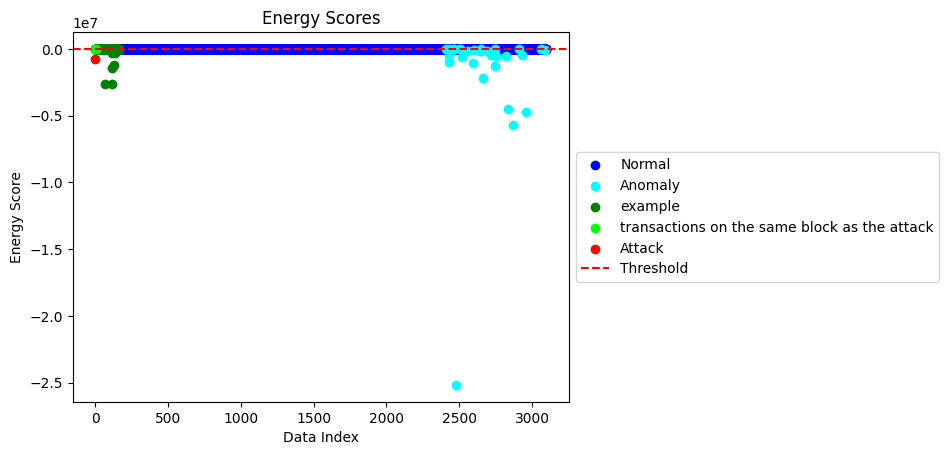

Found you
number of transactions with energy greater or equal to the attack in train is:  0  out of:  2325
number of transactions with energy greater or equal to the attack in test is:  8  out of:  775
number of transactions with energy greater or equal to the attack in example is:  4  out of:  162
true positive:  1.0
false positive:  0.9506172839506173
true negative:  0.04938271604938271
false negative:  0.0


In [ ]:
from sklearn import mixture



train_data, test_data = train_test_split(prep_data, test_size=0.25, random_state=40)

clf = mixture.BayesianGaussianMixture(n_components=1, covariance_type="full")
clf.fit(train_data)


# Get anomaly scores for test data
train_energy=clf.score_samples(train_data)
test_energy=clf.score_samples(test_data)
all_energy=np.concatenate((train_energy, test_energy), axis=0)

# Determine anomalies
threshold = np.percentile(all_energy, 1)
print(threshold)




normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

normal_indices = torch.where(normal_energy > threshold)[0]
anomaly_indices = torch.where(normal_energy <= threshold)[0]
attack = torch.tensor(clf.score_samples(anom.numpy()))
example = torch.tensor(clf.score_samples(exam.numpy()))

print(clf.score_samples(anom.numpy()))


plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
print(attack)

plt.scatter(range(len(example)), example, c='green', label='example')


plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')
plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

if(attack[0]<=threshold):
  print("Found you")
else:
  print("try again")


print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(torch.tensor(train_energy) <= attack[0])[0]), " out of: ", len(train_energy))
print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(torch.tensor(test_energy) <= attack[0])[0]), " out of: ", len(test_energy))
print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example <= attack[0])[0]), " out of: ", len(example))

attack = torch.tensor([attack[0]], dtype=torch.float)

false_pos=len(torch.where(example >= threshold)[0])/len(example)
true_pos=len(torch.where(attack <= threshold)[0])/len(attack)
false_neg=len(torch.where(attack > threshold)[0])/len(attack)
true_neg=len(torch.where(example < threshold)[0])/len(example)

print('true positive: ', true_pos)
print('false positive: ', false_pos)
print('true negative: ', true_neg)
print('false negative: ', false_neg)